# Log File einlesen

In [1]:
import re
import pandas as pd

with open("../berechnung.log", "r") as f:
    lines = f.readlines()
    
records_player = []
records_game = []

for line in lines:
    line = line.strip()
    
    m = re.search(
        r"Pitch Result: step size: (?P<step>\d+) \| game: (?P<game_id>\w+) \| zeit: (?P<time>[\d.]+) \| anzahl frame: (?P<n_frames>\d+)",
        line
    )
    if m:
        records_game.append({
            "step": int(m["step"]),
            "game_id": m["game_id"],
            "n_frames": int(m["n_frames"]),
            "time_sec": float(m["time"]),
        })
        continue
    
    m = re.search(
        r"Result Spieler (?P<player>\w+): frame step: (?P<step>\d+) \| game: (?P<game_id>\w+) \| zeit: (?P<time>[\d.]+) \| anzahl frame: (?P<n_frames>\d+) \| params: (?P<params>{.*?}) \| method: (?P<method>[\w.]+) \| sample: (?P<samplesize>\d+)",
        line
    )
    if m:
        params = eval(m["params"])
        records_player.append({
            "player": m["player"],
            "frames": int(m["n_frames"]),
            "step": int(m["step"]),
            "game_id": m["game_id"],
            "method": m["method"],
            "time_sec": float(m["time"]),
            "param_max_radius": params["max_radius"],
            "param_opt_step_size": params["opt_step_size"],
            "param_min_dist": params["min_dist"],
            "param_n": params["n"],
            "sample": int(m["samplesize"])
        })
        continue
    else:
        print(line)
    
    
df_games = pd.DataFrame(records_game)
df_player = pd.DataFrame(records_player)
df_player


,player,frames,step,game_id,method,time_sec,param_max_radius,param_opt_step_size,param_min_dist,param_n,sample
0,home_25,201,125,J03WQQ,random,391.1710,5,1,2,20,20
1,home_13,31,125,J03WQQ,random,41.9171,5,1,2,20,20
2,home_28,201,125,J03WQQ,random,304.8802,5,1,2,20,20
3,home_3,2,125,J03WQQ,random,2.1916,5,1,2,20,20
4,home_11,52,125,J03WQQ,random,68.6505,5,1,2,20,20
...,...,...,...,...,...,...,...,...,...,...,...
263,home_19,120,125,J03WR9,random,465.2886,5,1,2,50,50
264,home_23,14,125,J03WR9,random,53.5457,5,1,2,50,50
265,home_5,134,125,J03WR9,random,590.0155,5,1,2,50,50
266,home_7,120,125,J03WR9,random,475.9040,5,1,2,50,50


In [2]:
# Game DF auswerten
df_games_grouped = (df_games.groupby("step").agg(
    runs=("time_sec", "count"),
    time_sec=("time_sec", "mean"),
))
df_games_grouped["time_min"] = round(df_games_grouped["time_sec"] / 60, 2)
df_games_grouped

,runs,time_sec,time_min
step,,,
1,1,3963.246300,66.05
25,1,107.934300,1.80
125,8,26.335887,0.44


In [4]:
# Player DF mit 125 Step auswerten
df = df_player.copy()
df["method"] = df.apply(
    lambda row: f"{row['method']}_n{int(row['param_n'])}" if "random" in row["method"] else row["method"],
    axis=1
)
df["time_per_frame"] = df["time_sec"] / df["frames"]

by_step = (df.groupby(["step", "method"])
           .agg(runs=("time_sec", "count"),
                median_tpf=("time_per_frame", "median"))
           .reset_index()
           .sort_values(["step", "median_tpf"]))
# display(by_step)

# df = df[df["step"] == 125]

summary = (df.groupby(["method", "step"])
        .agg(runs=("time_sec", "count"),
             mean_total=("time_sec", "mean"),
             median_total=("time_sec", "median"),
             mean_tpf=("time_per_frame", "mean"),
             median_tpf=("time_per_frame", "median"),
             mean_sample=("sample", "mean"),
             median_sample=("sample", "median"),
             max_sample=("sample", "max")
        )
)
summary = summary.sort_values("median_tpf")
# display(summary)

per_player = (df.groupby(["player", "method"])
              .agg(median_tpf=("time_per_frame", "median"),
                   mean_tpf=("time_per_frame", "mean"))
              .reset_index()
            )
# display(per_player)

player_fair = (per_player.groupby("method")[["median_tpf", "mean_tpf"]]
               .median()
               .sort_values(by="median_tpf"))
# display(player_fair)

low_q, high_q = 0.05, 0.95
q_low = df.groupby(["method", "step"])["time_per_frame"].transform(lambda x: x.quantile(low_q))
q_high = df.groupby(["method", "step"])["time_per_frame"].transform(lambda x: x.quantile(high_q))

df_trim = df[(df["time_per_frame"].between(q_low, q_high))].copy()

pivot_total = pd.pivot_table(
    df,
    index=["step"],
    columns="method",
    values=["time_sec"],
    aggfunc="mean"
).round(3)
pivot_total_trim = pd.pivot_table(
    df_trim,
    index=["step"],
    columns="method",
    values=["time_sec"],
    aggfunc="mean"
).round(3)
pivot_mean = pd.pivot_table(
    df,
    index=["step"],
    columns="method",
    values=["time_per_frame"],
    aggfunc="mean"
).round(3)
pivot_mean_trim = pd.pivot_table(
    df_trim,
    index=["step"],
    columns="method",
    values=["time_per_frame"],
    aggfunc="mean"
).round(3)
pivot_max = pd.pivot_table(
    df,
    index=["step"],
    columns="method",
    values=["time_per_frame"],
    aggfunc="max"
).round(3)
pivot_max_trim = pd.pivot_table(
    df_trim,
    index=["step"],
    columns="method",
    values=["time_per_frame"],
    aggfunc="max"
).round(3)
display(pivot_total)
# display(pivot_total_trim)
display(pivot_mean)
# display(pivot_mean_trim)
display(pivot_max)
# display(pivot_max_trim)

time_sec                                            \
method all_positions all_positions_cut_1.0 random_cut_1.0_n100   
step                                                             
25               NaN              3025.713                 NaN   
125         1029.921               350.248             327.152   

                                                                                
method random_cut_1.0_n20 random_cut_1.0_n50 random_n100 random_n20 random_n50  
step                                                                            
25                    NaN                NaN         NaN   2730.608        NaN  
125                95.898            202.835      970.89    178.359    521.728

time_per_frame                                            \
method  all_positions all_positions_cut_1.0 random_cut_1.0_n100   
step                                                              
25                NaN                 9.888                 NaN   
125              7.73                 5.936               5.545   

                                                                                
method random_cut_1.0_n20 random_cut_1.0_n50 random_n100 random_n20 random_n50  
step                                                                            
25                    NaN                NaN         NaN      2.722        NaN  
125                 1.625              3.438       7.253      1.464      4.777

time_per_frame                                            \
method  all_positions all_positions_cut_1.0 random_cut_1.0_n100   
step                                                              
25                NaN                 9.888                 NaN   
125             9.285                 5.936               5.545   

                                                                                
method random_cut_1.0_n20 random_cut_1.0_n50 random_n100 random_n20 random_n50  
step                                                                            
25                    NaN                NaN         NaN      2.722        NaN  
125                 1.625              3.438       8.621     23.574     30.326

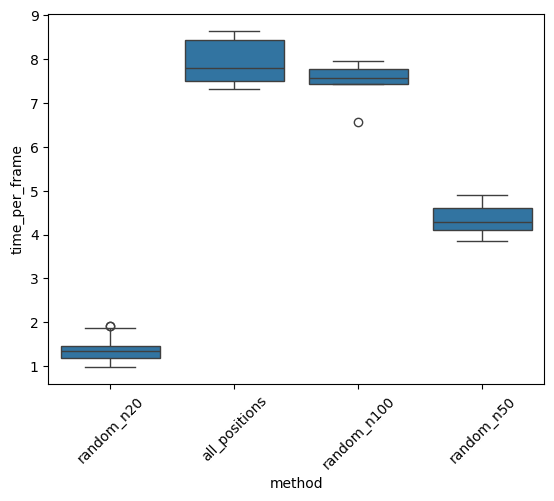

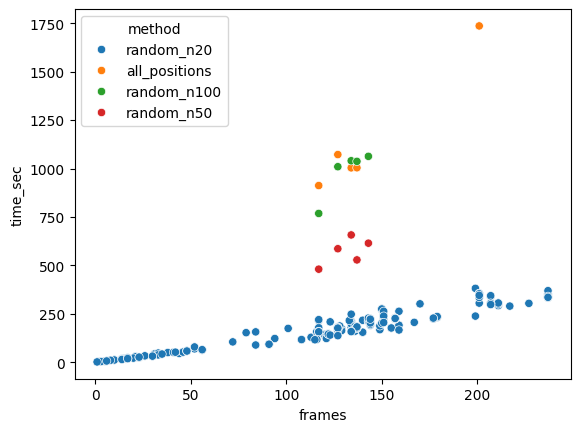

In [6]:
import seaborn as sns, matplotlib.pyplot as plt
df_125 = df_trim[df_trim["step"] == 125]
no_cut_mask = ~df_125["method"].str.contains("cut", case=False, na=False)
df_125 = df_125[no_cut_mask]
sns.boxplot(data=df_125, x="method", y="time_per_frame"); plt.xticks(rotation=45); plt.show()
sns.scatterplot(data=df_125, x="frames", y="time_sec", hue="method"); plt.show()


In [33]:
import numpy as np 
x_range = np.arange(-5, 5 + 1, 1)
y_range = np.arange(-5, 5 + 1, 1)
list = [(dx, dy) for dx in x_range for dy in y_range if np.sqrt(dx**2 + dy**2) <= 5]
len(list)


81